<a href="https://colab.research.google.com/github/amello69/cyberattacks_unsw15/blob/main/Two_models_for_IDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

##Import libraries and other first things
###This section takes care preliminaries:
* import libraries
* Declare useful functions
* load data
* create subsets of data for training, test and validation

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from google.colab import files
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report


###My Functions

In [ ]:
#This function loads the data
def getdata(csv):
  df = pd.read_csv(csv, sep=',') #load dataset from csv for Sample C
  return df


#This functions gets descriptive data from dataframe: counts for each attack type and each label
def getdestat (df):
  attack_cat_ct = df['attack_cat'].groupby(df['attack_cat']).count()
  label_ct = df['label'].groupby(df['label']).count()
  return attack_cat_ct, label_ct

#this function preprocesses the data to give data with only features of high importance. Please see feature selection notebook where ExtraTrees algorithm is used to select features from the dataset.
def process_data (df,et_features):
  #sample_set = df[0:175341] #get sample
  et_cols = et_features.columns #get column names
  X = df[et_cols] #features
  y = df['label'] #labels
  return X,y

'''
The follow functions are specific pecific to  ML models.
These functions:
  1. Reshape data
  2. Split data into train, test and validation sets as needed.

'''

def data_for_LTSM(X,y):
  #get shape of data
  xshape = X.shape[0]
  yshape = y.shape[0]
  fshape = X.shape[1]

  #reshape data for LSTM & MLP
  X1 =tf.reshape(X, shape=[xshape,1, fshape])
  y1 = tf.reshape(y, shape=[yshape,1,1])

  #get sample A - Train
  Xmtrain = X1[0:100000] # get train features
  ymtrain0 = y1[0:100000] # get train labels
  ymtrain = tf.squeeze(ymtrain0)
  #get sample B - Test
  Xval = X1[100000:175341] #get test features
  ytest0 = y1[100000:175341] #get test labels
  yval = tf.squeeze(ytest0)

  return Xmtrain, ymtrain, Xval, yval

def data_4_model(X,y):
  #get shape of data
  xeshape = X.shape[0]
  yeshape = y.shape[0]
  feshape = X.shape[1]

  #reshape data for LSTM & MLP
  Xptrain =tf.reshape(X, shape=[xeshape,1, feshape])
  yeval1 = tf.reshape(y, shape=[yeshape,1,1])
  yptrain = tf.squeeze(yeval1)

  return Xptrain, yptrain

def data_for_LSTM_alt(X0,y0):
  #get shape of data
  xshape = X0.shape[0]
  yshape = y0.shape[0]
  fshape = X0.shape[1]

  #reshape data for LSTM & MLP
  X1 =tf.reshape(X0, shape=[xshape,1, fshape])
  y1 = tf.reshape(y0, shape=[yshape,1,1])

  return X1, y1

from IPython.display import Audio, display

# Function to play an audio alert
def play_audio_alert():
    audio_file = 'https://upload.wikimedia.org/wikipedia/commons/1/1f/Be_arjun.wav'  # Replace with the path to your audio file
    display(Audio(audio_file, autoplay=True))

In [ ]:
#This function loads a saved model
def load_mymodel(path_model):
  #load model
  mymodel = pd.read_pickle(path_model)
  return mymodel

#This function obtains predictions from a model
def make_predictions(mymodel, x_test):
    # Make predictions
    y_pred = mymodel.predict(x_test)
    return y_pred
#This transforms predictions to a format that can be used for classification matrix
def prepreds(y_pred, y):

  y_pred = tf.squeeze(y_pred)
  y_pred0 = list(y_pred)

  y_testr = tf.squeeze(y)
  y_test0 = list(y_testr)

  # Convert the predictions and true labels into binary values
  y_pred_binary = np.round(y_pred0)
  y_test_binary = np.round(y_test0)

  # convert float values to int (precision, recall and f1_score functions can not handle float values)
  y_pred_b = y_pred_binary.astype(int)
  y_test_b = y_test_binary.astype(int)
  return y_pred_b, y_test_b

#Function for evaluating different classification models
def evalModel(y_pred_b, y_test_b):
  # Compute precision, recall, and F1-score
  precision_sl = precision_score(y_test_b, y_pred_b)
  recall_sl = recall_score(y_test_b, y_pred_b)
  f1score_sl = f1_score(y_test_b, y_pred_b)
  roc_auc_sl = roc_auc_score(y_test_b, y_pred_b)

  print("Precision:", precision_sl)
  print("Recall:", recall_sl)
  print("F1-score:", f1score_sl)
  print("AUC_ROC:", roc_auc_sl)

  # Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds
  fpr, tpr, thresholds = roc_curve(y_test_b, y_pred_b)

  # Calculate the area under the ROC curve (AUC)
  roc_auc = auc(fpr, tpr)

  # Plot the ROC curve
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC)')
  plt.legend(loc='lower right')
  plt.show()
  print(thresholds)





###Load and prepare all data

In [ ]:
#load data from train csv
df_og = pd.read_pickle("/content/drive/MyDrive/network dataset/df-bulk2.pk1")

#load data from test csv
df_test = pd.read_pickle("/content/drive/MyDrive/network dataset/df-bulk2t.pk1")

#load features names selected by extraTrees
et_features = pd.read_pickle("/content/drive/MyDrive/Pickles/et_sel.pk1")


#create dataframe from train.csv
X0,y0 = process_data(df_og, et_features)

#create dataframe from test.csv
X0t,y0t = process_data(df_test, et_features)

#get train, validation data from train csv dataframe for LSTM models
Xmtrain, ymtrain, Xval, yval = data_for_LTSM(X0,y0)

#get test data from test csv dataframe for final evaluation
Xptrain, yptrain = data_4_model(X0t,y0t)

#alternate data prep with larger samples
X01p = PowerTransformer("yeo-johnson").fit_transform(X0)
X0tp = PowerTransformer(method="yeo-johnson").fit_transform(X0t)


X0t1, y0t1 = data_for_LSTM_alt(X0tp,y0t)
X01, y01 = data_for_LSTM_alt(X01p,y0)




# **Supervised Model**

* Supervised learning uses labeled data to train a model to classify that data
* This is a good option when labeled data is readily available or there is a budget to bring in experts to label the data.
* Models train in this way perform well with data that is similar to the training data.
* It is import that a model is able to generalize well i.e. be good at classification with new data.


###Define a class with functions for trained LSTM & MLP model:

* Load model
* Create Predictions on data
* Evaluate Model



> This is a supervised model with data augmentation using random noise and attention.






In [ ]:
import numpy as np
import tensorflow as tf

#function to return the shape of first element in dataset
def auto_detect_input_shape(data):
    return data[0].shape

#function to build an LSTM MLP model
def build_model(input_shape):
    lstm_units = 64
    mlp_units = 32

    inputs = tf.keras.layers.Input(shape=input_shape)

    # LSTM layer with return_sequences=True to output sequences for attention
    lstm_output = tf.keras.layers.LSTM(lstm_units, return_sequences=True)(inputs)

    # Attention mechanism using a custom layer
    attention_output = AttentionLayer()(lstm_output)

    # MLP layer
    mlp_output = tf.keras.layers.Dense(mlp_units, activation='relu')(attention_output)

    # Output layer
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mlp_output)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

#Attention layer class which inherits from Layer in Keras
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        attention_scores = tf.matmul(inputs, self.W)
        attention_scores = tf.nn.softmax(attention_scores, axis=1)
        weighted_sum = tf.reduce_sum(inputs * attention_scores, axis=1)
        return weighted_sum

# model training function
def train_model(model, train_data, train_labels, epochs=5, batch_size=32):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size)

# model evaluation funciton
def evaluate_model(model, test_data, test_labels):
    loss, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")
    y_preds = model.predict(test_data)
    yp_b, y_b = prepreds(y_preds, test_labels)
    evalModel(yp_b, y_b)

# data augmentation
def augment_data(data, noise_factor=0.01):
    # Add data augmentation techniques here if needed (e.g., random noise, perturbations, etc.)
    augmented_data = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return augmented_data

def main():
    # Load your dataset here (assuming it's already preprocessed and split into train/test sets)
    train_data = X01
    train_labels = y01
    test_data = X0t1
    test_labels = y0t1
    '''
    train_data = np.load("train_data.npy")
    train_labels = np.load("train_labels.npy")
    test_data = np.load("test_data.npy")
    test_labels = np.load("test_labels.npy")
    '''

    # Autodetect input shape based on the first data sample
    input_shape = auto_detect_input_shape(train_data)

    # Build the model
    model = build_model(input_shape)

    # Data augmentation on the training set
    train_data = augment_data(train_data)

    # Train the model
    train_model(model, train_data, train_labels)

    # Evaluate the model on the test set
    evaluate_model(model, test_data, test_labels)




Epoch 1/5
5480/5480 [==============================] - 30s 5ms/step - loss: 0.1319 - accuracy: 0.9376
Epoch 2/5
5480/5480 [==============================] - 26s 5ms/step - loss: 0.1188 - accuracy: 0.9411
Epoch 3/5
5480/5480 [==============================] - 27s 5ms/step - loss: 0.1157 - accuracy: 0.9421
Epoch 4/5
5480/5480 [==============================] - 28s 5ms/step - loss: 0.1141 - accuracy: 0.9431
Epoch 5/5
2573/2573 [==============================] - 7s 3ms/step - loss: 0.2392 - accuracy: 0.8788
Test Loss: 0.23916761577129364, Test Accuracy: 0.8787591457366943
2573/2573 [==============================] - 5s 2ms/step
Precision: 0.8280072746167836
Recall: 0.984249536751081
F1-score: 0.8993932552561027
AUC_ROC: 0.8668815251322973


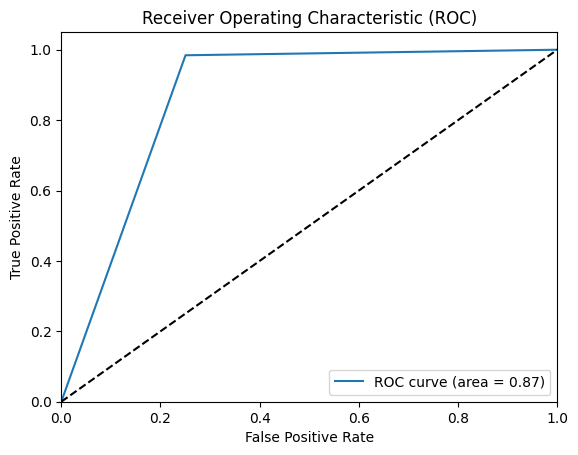

[2 1 0]


In [ ]:
# run the main function to cretae, compile, train and evaluate the model
if __name__ == "__main__":
    main()

In [ ]:
X01.shape

TensorShape([175341, 1, 28])

# **Self-Supervised Learning**


* In the real world data is not labeled
* labeling data can be expensive: money and man-hours
* labeling requires expert knowledge

But what if we did not have to label a thing?

* Self-supervised learning may help to solve this problem. It is perfect for situations where few pieces of labeled data exists. The real-world...

* Self-supervised learning is often used in computer vision. In this application a pretext task is selected and used to pretrain a model that will be used to finetune another model so that it can generate labels for that data. This is of course a very simplistic explanation of what is done.

* A common pretext task in computer vision applications is to make transformations (rotate, convert to grayscale) to the images then attempt to recreate the image from the transformation or differentiate this transformed image from images of a different distribution. For example, say we are looking at images for cats and we select one image of a white cat and transform this into greyscale. In our training data we will have greyscale images of cows to ensure that the model learns the difference.

What would an application of self-supervised learning be like in computer security?

This notebook explores such an application.




##Self-Supervised model

##Self-supervised model using inpainting

Epoch 1/2
5480/5480 [==============================] - 28s 5ms/step - loss: 1.0010 - mse: 1.0010
Epoch 2/2
5480/5480 [==============================] - 26s 5ms/step - loss: 1.0000 - mse: 1.0000
Epoch 1/2
5480/5480 [==============================] - 37s 6ms/step - loss: 0.1617 - accuracy: 0.9301 - val_loss: 0.2891 - val_accuracy: 0.8335
Epoch 2/2
2573/2573 [==============================] - 6s 2ms/step - loss: 0.2721 - accuracy: 0.8568
Test Loss: 0.27212417125701904, Test Accuracy: 0.8567749857902527
2573/2573 [==============================] - 5s 2ms/step
Precision: 0.7995070724389198
Recall: 0.9875143386570193
F1-score: 0.8836208598160357
AUC_ROC: 0.842054466625807


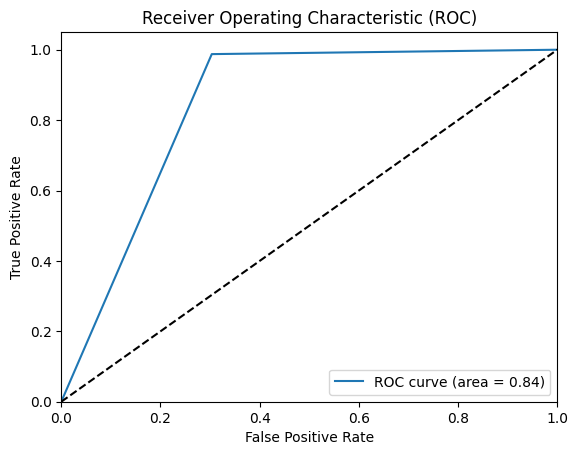

[2 1 0]


In [ ]:
import numpy as np
import tensorflow as tf

def auto_detect_input_shape(data):
    return data[0].shape

def build_model(input_shape):
    lstm_units = 64
    mlp_units = 32

    inputs = tf.keras.layers.Input(shape=input_shape)

    # LSTM layer
    lstm_output = tf.keras.layers.LSTM(lstm_units)(inputs)

    # MLP layer
    mlp_output = tf.keras.layers.Dense(mlp_units, activation='relu')(lstm_output)

    # Output layer
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mlp_output)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

def train_model(model, train_data, epochs=2, batch_size=32):
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    model.fit(train_data, train_data, epochs=epochs, batch_size=batch_size)

def evaluate_model(model, test_data):
    loss, _ = model.evaluate(test_data, test_data)
    print(f"Test Loss: {loss}")


def load_pretrained_model(model_path, input_shape):
    model = build_model(input_shape)
    model.load_weights(model_path)
    return model

def main():
    # Load your dataset here (assuming it's already preprocessed)
    data = X01
    train_labels = y01
    test_data = X0t1
    test_labels = y0t1

    # Autodetect input shape based on the first data sample
    input_shape = auto_detect_input_shape(data)

    # Build the model
    model = build_model(input_shape)

    # Train the model using self-supervised learning (inpainting pretext task)
    train_model(model, data)

    # Evaluate the model on the data (inpainting task does not require labels)
    # evaluate_model(model, test_data, test_labels)

    #save the model
    model.save('/content/drive/MyDrive/MyIDS/models/lstm_mlp_aug1a.h5')

    pretrained_model_path = '/content/drive/MyDrive/MyIDS/models/lstm_mlp_aug1a.h5'

    #Load the pre-trained model
    pretrained_model = load_pretrained_model(pretrained_model_path, input_shape)

    # Fine-tune the model on the intrusion detection task
    pretrained_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    pretrained_model.fit(data, train_labels, epochs= 2, batch_size=32, validation_data=(test_data, test_labels))

    # Evaluate the fine-tuned model on the test set
    loss, accuracy = pretrained_model.evaluate(test_data, test_labels)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")
    y_preds = pretrained_model.predict(test_data)
    yp_b, y_b = prepreds(y_preds, test_labels)
    evalModel(yp_b, y_b)

if __name__ == "__main__":
    main()


##Self-Supervised Model using inpainting with attention layer and data augmentation with random noise

Epoch 1/50
5480/5480 [==============================] - 39s 7ms/step - loss: 1.0008 - mse: 1.0008
Epoch 2/50
5480/5480 [==============================] - 38s 7ms/step - loss: 1.0001 - mse: 1.0001
Epoch 3/50
5480/5480 [==============================] - 38s 7ms/step - loss: 1.0001 - mse: 1.0001
Epoch 4/50
5480/5480 [==============================] - 37s 7ms/step - loss: 1.0001 - mse: 1.0001
Epoch 5/50
5480/5480 [==============================] - 39s 7ms/step - loss: 1.0001 - mse: 1.0001
Epoch 6/50
5480/5480 [==============================] - 37s 7ms/step - loss: 1.0001 - mse: 1.0001
Epoch 7/50
5480/5480 [==============================] - 38s 7ms/step - loss: 1.0001 - mse: 1.0001
Epoch 8/50
5480/5480 [==============================] - 39s 7ms/step - loss: 1.0001 - mse: 1.0001
Epoch 9/50
5480/5480 [==============================] - 37s 7ms/step - loss: 1.0001 - mse: 1.0001
Epoch 10/50
5480/5480 [==============================] - 37s 7ms/step - loss: 1.0001 - mse: 1.0001
Epoch 11/50
5480/54

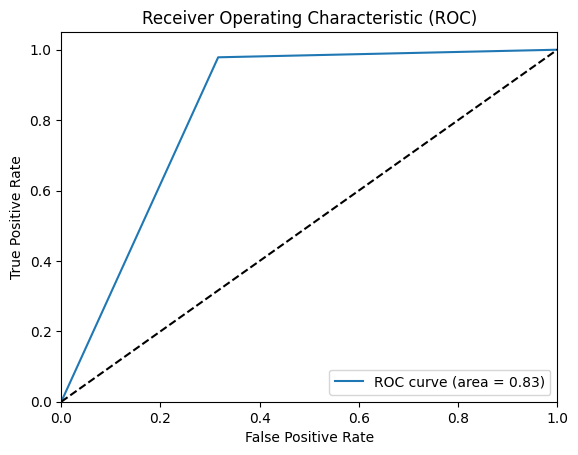

[2 1 0]


In [ ]:
import numpy as np
import tensorflow as tf

def auto_detect_input_shape(data):
    return data[0].shape

def build_model(input_shape):
    lstm_units = 128
    mlp_units = 64

    inputs = tf.keras.layers.Input(shape=input_shape)

    # LSTM layer with return_sequences=True to output sequences for attention
    lstm_output = tf.keras.layers.LSTM(lstm_units, return_sequences=True)(inputs)

    # Attention mechanism using a custom layer
    attention_output = AttentionLayer()(lstm_output)

    # MLP layer
    mlp_output = tf.keras.layers.Dense(mlp_units, activation='relu')(attention_output)

    # Output layer
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mlp_output)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        attention_scores = tf.matmul(inputs, self.W)
        attention_scores = tf.nn.softmax(attention_scores, axis=1)
        weighted_sum = tf.reduce_sum(inputs * attention_scores, axis=1)
        return weighted_sum

def train_model(model, train_data, epochs=50, batch_size=32):
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    model.fit(train_data, train_data, epochs=epochs, batch_size=batch_size)

def evaluate_model(model, test_data):
    loss, _ = model.evaluate(test_data, test_data)
    print(f"Test Loss: {loss}")

def augment_data(data, noise_factor=0.01):
    # Add data augmentation techniques here if needed (e.g., random noise, perturbations, etc.)
    augmented_data = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return augmented_data

def load_pretrained_model(model_path, input_shape):
    model = build_model(input_shape)
    model.load_weights(model_path)
    return model

def main():
    # Load your dataset here (assuming it's already preprocessed)
    data = X01
    train_labels = y01
    test_data = X0t1
    test_labels = y0t1

    # Autodetect input shape based on the first data sample
    input_shape = auto_detect_input_shape(data)

    # Build the model
    model = build_model(input_shape)

    # Data augmentation on the training set
    data = augment_data(data)

    # Train the model using self-supervised learning (inpainting pretext task)
    train_model(model, data)

    # Evaluate the model on the data (inpainting task does not require labels)
    # evaluate_model(model, test_data, test_labels)

    #save the model
    model.save('/content/drive/MyDrive/MyIDS/models/lstm_mlp_aug1b.h5')

    pretrained_model_path = '/content/drive/MyDrive/MyIDS/models/lstm_mlp_aug1b.h5'

    #Load the pre-trained model
    pretrained_model = load_pretrained_model(pretrained_model_path, input_shape)

    # Fine-tune the model on the intrusion detection task
    pretrained_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    pretrained_model.fit(data, train_labels, epochs= 50, batch_size=32, validation_data=(test_data, test_labels))

    # Evaluate the fine-tuned model on the test set
    loss, accuracy = pretrained_model.evaluate(test_data, test_labels)
    print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")
    y_preds = pretrained_model.predict(test_data)
    yp_b, y_b = prepreds(y_preds, test_labels)
    evalModel(yp_b, y_b)

if __name__ == "__main__":
    main()


# Thank You
Thank you for taking time to go through this notebook. I hope that it was helpful by providing things you can continue to develop.

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.